In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import numpy as np
import json
from collections import defaultdict, Counter
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score


## DESCRIPTIVE STADISTICS AND DATA VISUALIZATION

In [2]:
clindata = pd.read_csv('/Users/laiacoronassala/Desktop/VHIO/codisdef/clinical_biological_db_20230905.csv')
clindata.columns

Index(['Unnamed: 0', 'patient_id', 'DB', 'sex', 'DOB', 'EOT_reason',
       'primary_tlocation', 'BL_CT_date', 'first_CT_date', 'BR_CT_date',
       'PD_CT_date', 'RECIST', 'trial_start_date', 'PFS_months', 'OS_months',
       'last_FU', 'cb_5mo', 'cb_4mo', 'status_at_last_FU', 'n_lesions',
       'n_loc_lesions', 'age', 'cb_PFS', 'treatment', 'total_seg_vol',
       'PFS_censored', 'liver_met', 'baseline_lymphos', 'baseline_neutroph',
       'baseline_leucocytes', 'baseline_platelets', 'baseline_albumin',
       'baseline_LDH', 'baseline_num_met_organs', 'baseline_ECOG'],
      dtype='object')

In [3]:
cols = ['patient_id','sex','primary_tlocation','n_lesions','age','treatment','total_seg_vol',
        'liver_met','baseline_lymphos', 'baseline_neutroph',
       'baseline_leucocytes', 'baseline_platelets', 'baseline_albumin',
       'baseline_LDH', 'baseline_num_met_organs', 'baseline_ECOG', 'cb_4mo']
clindata = clindata[cols]
clindata

,patient_id,sex,primary_tlocation,n_lesions,age,treatment,total_seg_vol,liver_met,baseline_lymphos,baseline_neutroph,baseline_leucocytes,baseline_platelets,baseline_albumin,baseline_LDH,baseline_num_met_organs,baseline_ECOG,cb_4mo
0,14947437,female,ovary,10,72,combo immuno,47417.902780,0,2.0,3.4,6.29,302.0,3.1,418.0,1.0,1.0,1
1,10049517,male,esophagus,3,61,combo immuno,54198.513890,0,3.0,5.0,9.00,189.0,4.1,377.0,2.0,0.0,1
2,10262640,male,kidney,4,50,combo immuno,40001.152770,1,1.6,4.6,7.12,224.0,3.8,323.0,3.0,1.0,0
3,10599018,male,head_and_neck,4,54,combo immuno,8589.875000,0,2.2,3.2,6.10,217.0,4.6,446.0,3.0,0.0,1
4,10897916,female,skin,3,58,combo immuno,27891.166660,0,2.0,2.4,4.93,298.0,4.1,283.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,18895067,male,liver,1,37,monotherapy,238646.916700,0,1.0,3.6,5.31,256.0,4.3,415.0,2.0,0.0,1
182,19309727,female,cervix,1,45,monotherapy,4228.861111,0,1.0,2.8,4.21,171.0,3.8,318.0,2.0,1.0,1
183,260626,female,pleura,1,65,monotherapy,1860.968750,0,1.1,4.0,6.12,455.0,3.2,443.0,3.0,0.0,1
184,412386,female,cervix,2,67,monotherapy,13703.305550,0,1.0,4.4,6.04,275.0,3.9,NaN,2.0,0.0,1


In [4]:
#Counting
print("Number of unique patients: ", clindata['patient_id'].nunique())
print("Sex:", clindata['sex'].value_counts())
print("tumor locations:", clindata['primary_tlocation'].value_counts())
print("Response:", clindata['cb_4mo'].value_counts())
print("Treatment:", clindata['treatment'].value_counts())

Number of unique patients:  186
Sex: sex
male      115
female     71
Name: count, dtype: int64
tumor locations: primary_tlocation
lung             50
colorectal       19
skin             18
breast           13
cervix           12
head_and_neck    11
bladder           9
ovary             7
thyroid           6
adrenal           6
esophagus         5
stomach           5
pleura            4
bone              4
kidney            4
liver             3
pancreas          3
UGE               2
thymus            2
NSCLC             1
biliary_tract     1
penis             1
Name: count, dtype: int64
Response: cb_4mo
0    102
1     84
Name: count, dtype: int64
Treatment: treatment
monotherapy      111
combo immuno      73
combo immuno       2
Name: count, dtype: int64


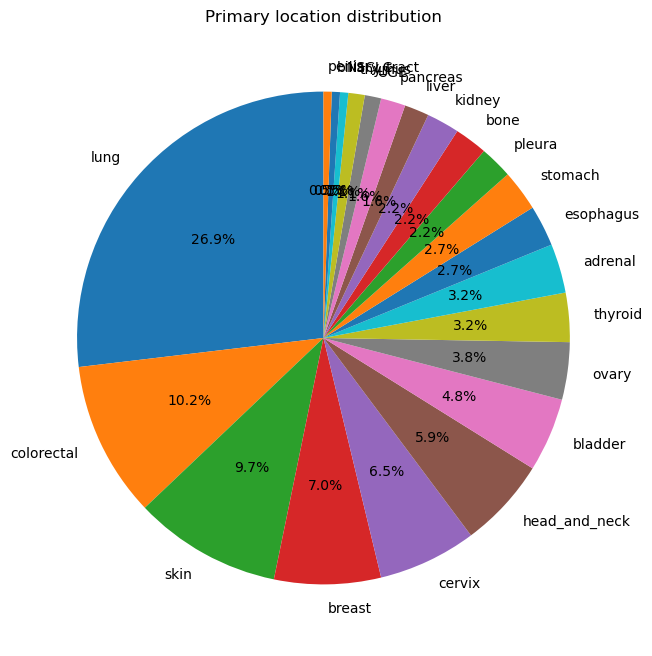

In [5]:
loc = clindata['primary_tlocation'].value_counts()
loc.plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(10, 8))
plt.title('Primary location distribution')
plt.ylabel('')
plt.show()

## PREPROCESSING

In [6]:
clindata.columns

Index(['patient_id', 'sex', 'primary_tlocation', 'n_lesions', 'age',
       'treatment', 'total_seg_vol', 'liver_met', 'baseline_lymphos',
       'baseline_neutroph', 'baseline_leucocytes', 'baseline_platelets',
       'baseline_albumin', 'baseline_LDH', 'baseline_num_met_organs',
       'baseline_ECOG', 'cb_4mo'],
      dtype='object')

In [7]:
nas = clindata.isna().sum()
print(nas) #we are dropping the LDH column

patient_id                  0
sex                         0
primary_tlocation           0
n_lesions                   0
age                         0
treatment                   0
total_seg_vol               0
liver_met                   0
baseline_lymphos            1
baseline_neutroph           1
baseline_leucocytes         1
baseline_platelets          1
baseline_albumin            1
baseline_LDH               25
baseline_num_met_organs     1
baseline_ECOG               4
cb_4mo                      0
dtype: int64


In [8]:
#drop column
#clindata = clindata.drop(columns='baseline_LDH', axis=1)
#knn for the remaining missing values
from sklearn.impute import KNNImputer
# Selecting the columns for imputation
columns_for_imputation = [
    "baseline_lymphos", "baseline_neutroph", "baseline_leucocytes",
    "baseline_platelets", "baseline_albumin",
    "baseline_num_met_organs", "baseline_ECOG"
]
data_for_imputation = clindata[columns_for_imputation]
# Using KNN imputer with n_neighbors=5
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(data_for_imputation)
# Creating a DataFrame for the imputed data
imputed_data_df = pd.DataFrame(imputed_data, columns=columns_for_imputation)
for column in columns_for_imputation:
    clindata[column] = imputed_data_df[column]

In [9]:
y = clindata['cb_4mo']
patients = clindata[['patient_id']]
toscale = clindata[['n_lesions', 'age','total_seg_vol', 'liver_met', 'baseline_lymphos',
       'baseline_neutroph', 'baseline_leucocytes', 'baseline_platelets',
       'baseline_albumin', 'baseline_num_met_organs',
       'baseline_ECOG']]
binary = clindata[['sex','treatment',]]
categorical = clindata[['primary_tlocation']]

In [11]:
#scaling
scaler = StandardScaler()
scaled = scaler.fit_transform(toscale)
scaled = pd.DataFrame(scaled, columns=toscale.columns)

#encoding
le = LabelEncoder()
binary['sex'] = le.fit_transform(binary['sex']) # 1 es male i 0 es female
binary['treatment'] = binary['treatment'].str.strip()
binary['treatment'] = le.fit_transform(binary['treatment']) # 0 combo 1 monotherapy


#threshold a 10
primarytumor = ['lung','colorectal','skin','breast','cervix','head_and_neck']
for i in range(len(categorical)):
    if categorical.loc[i,'primary_tlocation'] not in primarytumor:
        categorical.loc[i,'primary_tlocation'] = 'other'

/var/folders/r_/_x49m5kn0v98s1f52zqmrt1m0000gn/T/ipykernel_4150/1123949147.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary['sex'] = le.fit_transform(binary['sex']) # 1 es male i 0 es female
/var/folders/r_/_x49m5kn0v98s1f52zqmrt1m0000gn/T/ipykernel_4150/1123949147.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary['treatment'] = binary['treatment'].str.strip()
/var/folders/r_/_x49m5kn0v98s1f52zqmrt1m0000gn/T/ipykernel_4150/1123949147.py:10: SettingWithCopyWarning: 
A value is trying to be

In [12]:
X= pd.concat([scaled, binary, categorical], axis=1)

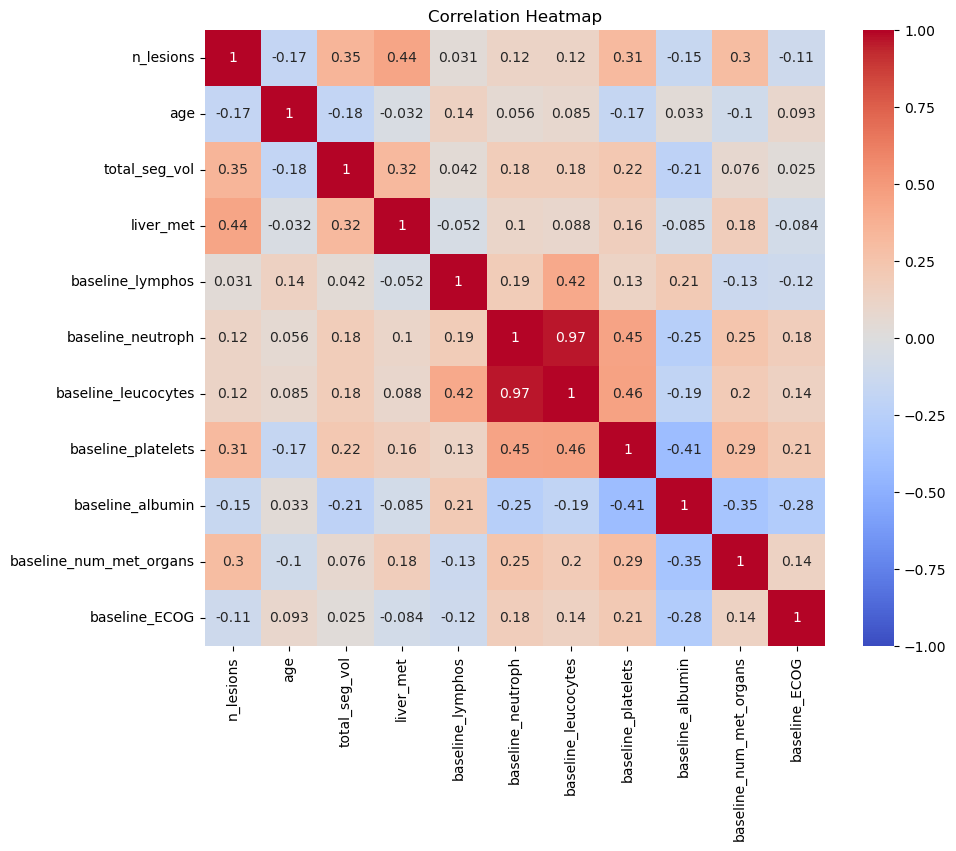

In [13]:
dataheat = X[['n_lesions', 'age', 'total_seg_vol', 'liver_met', 'baseline_lymphos',
       'baseline_neutroph', 'baseline_leucocytes', 'baseline_platelets',
       'baseline_albumin', 'baseline_num_met_organs',
       'baseline_ECOG']]

correlation_matrix = dataheat.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [13]:
#one hot encoding
#dummies = pd.get_dummies(X['primary_tlocation'], prefix='encod')
#dummies = dummies.astype(int)
#Xdef = pd.concat([X.drop('primary_tlocation', axis=1), dummies], axis=1)

In [14]:
# one hot encoding modification to -0.5 and 0.5
dummies = pd.get_dummies(X['primary_tlocation'], prefix='encod')
dummies = dummies - 0.5
Xdef = pd.concat([X.drop('primary_tlocation', axis=1), dummies], axis=1)

In [18]:
#saving a csv with the cleaned clinical variables
cleandata = pd.concat([patients,Xdef,y], axis = 1)
cleandata.to_csv("cleanclinicalKNN.csv")

In [19]:
#ML
def lasso_fselection(X_train, y_train, inner_cv):
    pipe = Pipeline([
        ('selector', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=500, random_state=123))),
        ('classifier', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=500))
    ])
    param_distributions = {
        'selector__estimator__C': [0.01, 0.1, 1, 10],  
        'classifier__l1_ratio': [0.3,0.5,1]
    }
    
    rs = RandomizedSearchCV(pipe, param_distributions=param_distributions, n_iter=30, scoring='roc_auc', cv=inner_cv)
    rs.fit(X_train, y_train.values.ravel())
    selected_features = X_train.columns[rs.best_estimator_.named_steps['selector'].get_support()]
    results = {
        'selected_features': selected_features,
        'estimator_C': rs.best_params_['selector__estimator__C'],
        'l1_ratio': rs.best_params_['classifier__l1_ratio']
    }
    return results
    

In [21]:
def flexible_nested_cv_optimized(X, y, outer_cv, inner_cv):

    inner_results = []
    outer_results = []
    
    outer_fold_counter = 1  

    for train_idx_outer, val_idx_outer in outer_cv.split(X, y):
        feature_counts = defaultdict(int)
        C_counts = defaultdict(int)
        l1_ratio_counts = defaultdict(int)
        
        inner_fold_counter = 1  

        for train_idx_inner, val_idx_inner in inner_cv.split(X.iloc[train_idx_outer], y.iloc[train_idx_outer]):
            X_train_inner, y_train_inner = X.iloc[train_idx_inner], y.iloc[train_idx_inner]
            X_val_inner, y_val_inner = X.iloc[val_idx_inner], y.iloc[val_idx_inner]
            
            results_inner = lasso_fselection(X_train_inner, y_train_inner, inner_cv)
            final_features = results_inner['selected_features']
         
            for feature in final_features:
                feature_counts[feature] += 1
            C_counts[results_inner['estimator_C']] += 1
            l1_ratio_counts[results_inner['l1_ratio']] += 1
            
            inner_model = LogisticRegression(penalty='elasticnet', solver='saga', C=results_inner['estimator_C'], 
                                             l1_ratio=results_inner['l1_ratio'], max_iter=500, random_state=123)
            
            inner_model.fit(X_train_inner[final_features], y_train_inner.values.ravel())
            y_pred_inner = inner_model.predict_proba(X_val_inner[final_features])[:, 1]
            auc_inner = roc_auc_score(y_val_inner, y_pred_inner)
            
            inner_results.append({
                'Fold': 'outer_' + str(outer_fold_counter)+'_inner_' + str(inner_fold_counter),
                'Features': final_features, 
                'C': results_inner['estimator_C'], 
                'l1_ratio': results_inner['l1_ratio'],
                'AUC': auc_inner
            })
        
            inner_fold_counter += 1  

        most_common_features = [feature for feature, _ in Counter(feature_counts).most_common(5)]  
        most_common_C = Counter(C_counts).most_common(1)[0][0]
        most_common_l1_ratio = Counter(l1_ratio_counts).most_common(1)[0][0]
        
        X_train_outer, y_train_outer = X.iloc[train_idx_outer], y.iloc[train_idx_outer]
        X_val_outer, y_val_outer = X.iloc[val_idx_outer], y.iloc[val_idx_outer]
        
        final_model = LogisticRegression(penalty='elasticnet', solver='saga', C=most_common_C, l1_ratio=most_common_l1_ratio, max_iter=500, random_state=123)
        final_model.fit(X_train_outer[most_common_features], y_train_outer.values.ravel())
        y_pred_outer = final_model.predict_proba(X_val_outer[most_common_features])[:, 1]
        auc_outer = roc_auc_score(y_val_outer, y_pred_outer)
        
        outer_results.append({
            'Fold': 'outer_fold_' + str(outer_fold_counter),  
            'Features': most_common_features,
            'C': most_common_C,
            'l1_ratio': most_common_l1_ratio,
            'AUC': auc_outer
        })
        
        outer_fold_counter += 1 

    return pd.DataFrame(inner_results), pd.DataFrame(outer_results)

In [23]:
def final_model(X, y, outer_results_df, odir):
    all_features = [feat for sublist in outer_results_df['Features'].tolist() for feat in sublist]
    most_common_features = [feature for feature, _ in Counter(all_features).most_common(5)]
    
    most_common_C = Counter(outer_results_df['C']).most_common(1)[0][0]
    most_common_l1_ratio = Counter(outer_results_df['l1_ratio']).most_common(1)[0][0]
    
    final_model = LogisticRegression(penalty='elasticnet', solver='saga', C=most_common_C, 
                                     l1_ratio=most_common_l1_ratio, max_iter=500)
    final_model.fit(X[most_common_features], y.values.ravel())
    
    coefficients = final_model.coef_[0]
    intercept = final_model.intercept_[0]
    
    avg_auc = outer_results_df['AUC'].mean()
    print(avg_auc)
    std_auc = outer_results_df['AUC'].std()
    
    results = {
        'Average AUC': avg_auc,
        'Standard Deviation AUC': std_auc,
        'Most Common Hyperparameters': {
            'C': most_common_C,
            'l1_ratio': most_common_l1_ratio
        },
        'Model Coefficients': dict(zip(most_common_features, coefficients)),
        'Model Intercept': intercept,
        'Selected Features': most_common_features
    }
    
    final_model_path = os.path.join(odir, name+".json")
    with open(final_model_path, 'w') as f:
        json.dump(results, f, indent=4)

    return final_model_path

In [24]:
odir = '/Users/laiacoronassala/Desktop/predicting_immunotherapy_response'
name = 'clinicalonlyKNN-0.5'
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
inner_results_df, outer_results_df=flexible_nested_cv_optimized(Xdef, y, outer_cv, inner_cv)
final_results = final_model(Xdef, y, outer_results_df, odir)

/Users/laiacoronassala/opt/anaconda3/envs/envlaia/lib/python3.12/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/laiacoronassala/opt/anaconda3/envs/envlaia/lib/python3.12/site-packages/sklearn/feature_selection/_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/Users/laiacoronassala/opt/anaconda3/envs/envlaia/lib/python3.12/site-packages/sklearn/feature_selection/_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/Users/laiacoronassala/opt/anaconda3/envs/envlaia/lib/python3.12/site-packages/sklearn/feature_selection/_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/Users/l

0.6993417366946779


/Users/laiacoronassala/opt/anaconda3/envs/envlaia/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/laiacoronassala/opt/anaconda3/envs/envlaia/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/laiacoronassala/opt/anaconda3/envs/envlaia/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Us